# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive/CS194-26/Final

Mounted at /content/drive
/content/drive/MyDrive/CS194-26/Final


In [ ]:
import os
import numpy as np
from tqdm.notebook import tqdm
import cv2
import skimage as sk
from skimage import transform
import skimage.io as skio
import matplotlib.pyplot as plt


from scipy.sparse.linalg import lsqr
from scipy.sparse import csr_matrix, lil_matrix


In [ ]:
def get_image(path):
  im = plt.imread(path)
  im = im.astype(float)
  return im

def show(im, figsize = 10, cmap=None):
  # Uses matplotlib in the backend to show images
  plt.figure(figsize=(figsize,figsize))
  plt.imshow(im, cmap=cmap)


# Part 2.1 (Toy Problem)

In [ ]:
def toy_matching(source):
  """
  We should have im1.shape == (y, x, 3)

  Our equations are as follows: for x = 0, y = 0 we have v[0,0] == s[0,0]
  
  """
  H, W, C = source.shape
  
  im2var = np.zeros((H, W, C))
  for i in range(len(im2var.ravel())):
    im2var.ravel()[i] = int(i)

  n_eq = C * (2 * im2var.size - 1) # For each pixel in each channel, there are 2 equations (except the top corner)
  A = lil_matrix((n_eq, im2var.size)) 
  b = np.zeros((n_eq, 1))
  e = 0
  
  for c in tqdm(range(C), leave = False):

    # Condition on the top corner of the image
    A[e, im2var[0,0,c]] = 1
    b[e,0] = source[0,0,c]
    e += 1

    # Incrementing x
    for y in range(im2var.shape[0] - 1):
      for x in range(im2var.shape[1] - 1):
        A[e, im2var[y, x, c]] = -1
        A[e, im2var[y,x+1, c]] = 1
        b[e,0] = source[y,x+1,c] - source[y,x,c]
        e += 1
    
    # Incrementing y
    for y in range(im2var.shape[0] - 1):
      for x in range(im2var.shape[1] - 1):
        A[e, im2var[y, x, c]] = -1
        A[e, im2var[y+1,x, c]] = 1
        b[e,0] = source[y+1,x,c] - source[y,x,c]
        e += 1

  A = csr_matrix(A) # Convert to csr format for better lsqr times
  v = lsqr(A, b)[0]

  # Putting the values from v into an output image
  output = np.zeros(source.shape)
  for y in range(H):
    for x in range(W):
      for c in range(C):
        output[y,x,c] = v[int(im2var[y,x,c])]

  return output

  

In [ ]:
output = toy_matching(temple[:200, :200])

  0%|          | 0/3 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Maximum values in each array:   1.0000296484184488  |  1.0


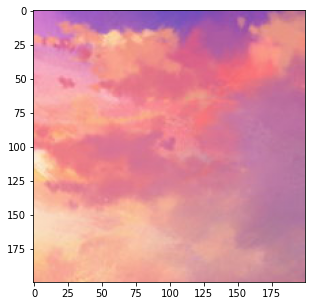

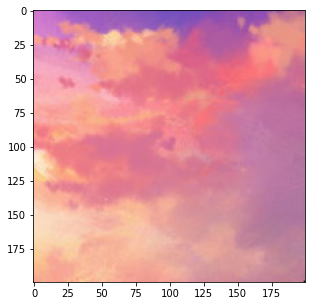

In [ ]:
show(temple[:200, :200], figsize=5)
show(output, figsize=5)

print("Maximum values in each array:  ", np.max(output), ' | ', np.max(temple[:200, :200]))

# Part 2.2

In [ ]:
def gradient_blend(source, target, source_mask):
  source = np.pad(source, [(1,1), (1,1), (0,0)], 'edge')
  target = np.pad(target, [(1,1), (1,1), (0,0)], 'edge')
  source_mask = np.pad(source_mask, [(1,1), (1,1)])
  assert source.shape == target.shape

  H, W, C = source.shape

  assert C == 3

  im2var = np.zeros((H, W, C))
  for i in range(len(im2var.ravel())):
    im2var.ravel()[i] = int(i)

  n_eq = int(np.sum(source_mask)) * 4 * 3 # 4 conditions per pixel int he mask * 3 channels
  A = lil_matrix((n_eq, im2var.size))
  b = np.zeros((n_eq))

  e = 0

  initial_conditions = False
  for c in tqdm(range(C), leave = False, desc = 'Adding gradient conditions by channel'):
    for y in tqdm(range(im2var.shape[0] - 1), leave = False,):
      for x in range(im2var.shape[1] - 1):
        if source_mask[y,x]:

          # Summation 1, x+1
          if source_mask[y,x+1]:
            A[e, im2var[y, x, c]] = -1
            A[e, im2var[y,x+1, c]] = 1
            b[e] = source[y,x+1,c] - source[y,x,c]
            e += 1
          # Summation 2, x+1
          else:
            A[e, im2var[y, x, c]] = 1
            b[e] = source[y,x,c] - source[y,x+1,c] + target[y,x+1,c]
            e += 1

          # Summation 1, x-1
          if source_mask[y,x-1]:
            A[e, im2var[y, x, c]] = -1
            A[e, im2var[y,x-1, c]] = 1
            b[e] = source[y,x-1,c] - source[y,x,c]
            e += 1
          # Summation 2, x-1
          else:
            A[e, im2var[y, x, c]] = 1
            b[e] = source[y,x,c] - source[y,x-1,c] + target[y,x-1,c]
            e += 1

          # Summation 1, y+1
          if source_mask[y+1,x]:
            A[e, im2var[y, x, c]] = -1
            A[e, im2var[y+1,x, c]] = 1
            b[e] = source[y+1,x,c] - source[y,x,c]
            e += 1
          # Summation 2, y+1
          else:
            A[e, im2var[y, x, c]] = 1
            b[e] = source[y,x,c] - source[y+1,x,c] + target[y+1,x,c]
            e += 1

          # Summation 1, y-1
          if source_mask[y-1,x]:
            A[e, im2var[y, x, c]] = -1
            A[e, im2var[y-1,x, c]] = 1
            b[e] = source[y-1,x,c] - source[y,x,c]
            e += 1
          # Summation 2, y-1
          else:
            A[e, im2var[y, x, c]] = 1
            b[e] = source[y,x,c] - source[y-1,x,c] + target[y-1,x,c]
            e += 1


  assert e == n_eq

  A = csr_matrix(A) # Convert to csr format for better lsqr times
  v = lsqr(A, b)[0]

  # Putting the values from v into source image
  for y in range(H):
    for x in range(W):
      for c in range(C):
        if source_mask[y,x]:
          target[y,x,c] = v[int(im2var[y,x,c])]

  return target[1:-1,1:-1]  # Remove the padding



def advanced_gradient_blend(source, target, source_mask, color_weight=.05):
  source = np.pad(source, [(1,1), (1,1), (0,0)], 'edge')
  target = np.pad(target, [(1,1), (1,1), (0,0)], 'edge')
  source_mask = np.pad(source_mask, [(1,1), (1,1)])
  assert source.shape == target.shape

  H, W, C = source.shape

  assert C == 3

  im2var = np.zeros((H, W, C))
  for i in range(len(im2var.ravel())):
    im2var.ravel()[i] = int(i)

  n_eq = int(np.sum(source_mask)) * 4 * 3 + (np.sum(source_mask > 0) * 3) # 4 conditions per pixel int he mask * 3 channels
  A = lil_matrix((n_eq, im2var.size))
  b = np.zeros((n_eq))

  e = 0

  initial_conditions = False
  for c in tqdm(range(C), leave = False, desc = 'Adding gradient conditions by channel'):
    for y in tqdm(range(im2var.shape[0] - 1), leave = False,):
      for x in range(im2var.shape[1] - 1):
        if source_mask[y,x]:

          A[e, im2var[y,x,c]] = color_weight
          b[e] = source[y,x,c] * color_weight
          e += 1

          # Summation 1, x+1
          if source_mask[y,x+1]:
            A[e, im2var[y, x, c]] = -1
            A[e, im2var[y,x+1, c]] = 1
            b[e] = source[y,x+1,c] - source[y,x,c]
            e += 1
          # Summation 2, x+1
          else:
            A[e, im2var[y, x, c]] = 1
            b[e] = source[y,x,c] - source[y,x+1,c] + target[y,x+1,c]
            e += 1

          # Summation 1, x-1
          if source_mask[y,x-1]:
            A[e, im2var[y, x, c]] = -1
            A[e, im2var[y,x-1, c]] = 1
            b[e] = source[y,x-1,c] - source[y,x,c]
            e += 1
          # Summation 2, x-1
          else:
            A[e, im2var[y, x, c]] = 1
            b[e] = source[y,x,c] - source[y,x-1,c] + target[y,x-1,c]
            e += 1

          # Summation 1, y+1
          if source_mask[y+1,x]:
            A[e, im2var[y, x, c]] = -1
            A[e, im2var[y+1,x, c]] = 1
            b[e] = source[y+1,x,c] - source[y,x,c]
            e += 1
          # Summation 2, y+1
          else:
            A[e, im2var[y, x, c]] = 1
            b[e] = source[y,x,c] - source[y+1,x,c] + target[y+1,x,c]
            e += 1

          # Summation 1, y-1
          if source_mask[y-1,x]:
            A[e, im2var[y, x, c]] = -1
            A[e, im2var[y-1,x, c]] = 1
            b[e] = source[y-1,x,c] - source[y,x,c]
            e += 1
          # Summation 2, y-1
          else:
            A[e, im2var[y, x, c]] = 1
            b[e] = source[y,x,c] - source[y-1,x,c] + target[y-1,x,c]
            e += 1


  assert e == n_eq

  A = csr_matrix(A) # Convert to csr format for better lsqr times
  v = lsqr(A, b)[0]

  # Putting the values from v into source image
  for y in range(H):
    for x in range(W):
      for c in range(C):
        if source_mask[y,x]:
          target[y,x,c] = v[int(im2var[y,x,c])]

  return target[1:-1,1:-1]  # Remove the padding




In [ ]:
output1 = gradient_blend(beautiful_world, temple, mask[:,:,0])
show(output1, figsize = 30)

Output hidden; open in https://colab.research.google.com to view.

Adding gradient conditions by channel:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


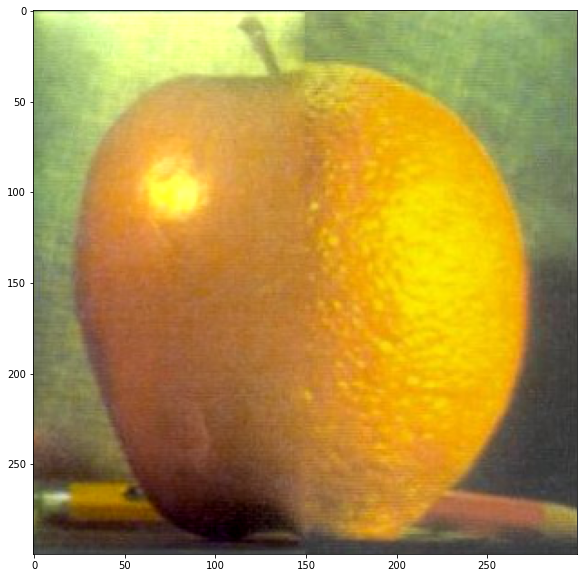

In [11]:
mask = np.zeros_like(get_image('orange.jpeg'))
for i in range(int(len(mask[0])/2)):
  mask[:,i,:] = 1

orange = get_image('orange.jpeg')/255
apple = get_image('apple.jpeg')/255

show(gradient_blend(apple, orange, mask[:,:,0]))

In [ ]:
output2 = advanced_gradient_blend(beautiful_world, temple, mask[:,:,0], color_weight = .02)
show(output2, figsize = 30)

Output hidden; open in https://colab.research.google.com to view.

# Misc

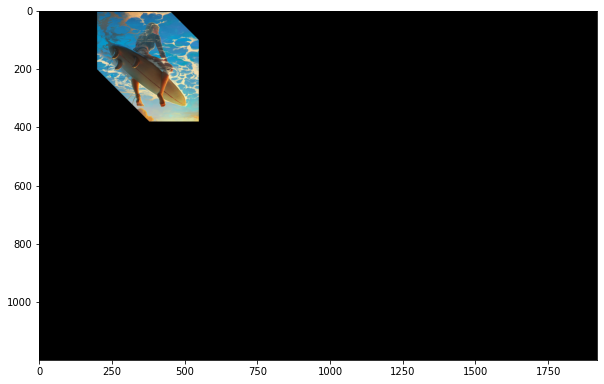

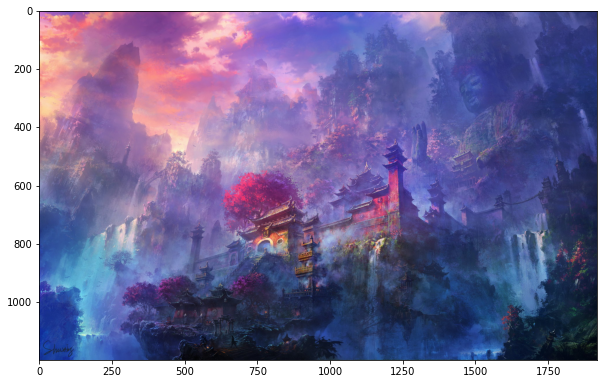

In [ ]:
beautiful_world = get_image('beautiful_world.jpg')/255
temple = get_image('temple.jpg')/255
mask = np.zeros_like(beautiful_world)
mask[:380, 200:550, :] = 1

for i in range(150, 380):
  for j in range(200, i):
    mask[i,j]=0

for j in range(450, 700):
  for i in range(0, j-450):
    mask[i,j]=0

mask = np.pad(mask, ((0, 564), (0, 1020), (0, 0)))
beautiful_world = np.pad(beautiful_world, ((0, 564), (0, 1020), (0, 0)))

show(beautiful_world * mask)
show(temple)